
### Analysis Real Estate Prices in Hong Kong
Author: KW.Loh, MsC Comp7103 Assignment Sem 1 2023<br> 
Email :mweng02@connect.hku.hk

In [2]:
### Library 
import numpy as np, pandas as pd , datetime as dt, seaborn as sns, pickle 
import folium
from folium import plugins
import matplotlib.pyplot as plt,  
from matplotlib.image import imread
import PreProcessing 
import warnings
# Disable warnings emitted by warnings.warn calls from different packages
warnings.filterwarnings('ignore')

#### STEP 1 Dataset : Residential real estate sold in the period 2016 - 2019 in Hong Kong 

The transaction dataset were obtained from a vendor that comprise of residential transaction in Hong kong from 2016 to 2019. There are 230,000++ records in the datasets and first fed into PreProcessing.Py to cleansing the datasets and the following new features had been created: <br> a) New Sales and Resales <br> b) Property_Type <br> c) Buildng Age <br> d) UnitSize <br> e) Floor Type <br>

At the same time, I had developed GeoCoder.py to call the GOOGLE MAP API to collect the lattitude and longitude of the distinct projectname and selected POI such as MTR and stored at JSON file. Next, I had further created a few more feature based on the distance between the POI and selected project name. </br>  

All the data are stored in Data/ Folder and the details on how to execute the two python scripts are available in the PreProcessing.Py. 
<br>


In [3]:
### The dataset has been processed and pre-clean in PreProcessing.Py
with open('Data/TransactionData.pkl', 'rb') as file_name:
    HK = pickle.load(file_name)

In [4]:
HK.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 238046 entries, 2019-12-31 to 2016-01-01
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Project_Name       238046 non-null  object 
 1   INST_DATE          238046 non-null  object 
 2   Sale_Type          238046 non-null  object 
 3   Property_Type      238046 non-null  object 
 4   Sale_Year          238046 non-null  int64  
 5   D_CODE             238046 non-null  object 
 6   BuildingAge        238046 non-null  int64  
 7   UnitSize           238046 non-null  int64  
 8   FLOOR              238046 non-null  int64  
 9   FloorType          238046 non-null  int64  
 10  combined_address   238046 non-null  object 
 11  Distance_TO_MRT    238046 non-null  float64
 12  TOTNFA             238046 non-null  float64
 13  NET_PSF            238046 non-null  int64  
 14  lat                238046 non-null  float64
 15  long               238046 non-null 

In [5]:
HK.shape

(238046, 19)

In [6]:
HK = HK[(HK['NET_PSF'] <100000) & (HK['TOTNFA'] <10000)]
#HK = HK.drop(["CBD"],axis =1)
HK['MRT'] = HK['MRT'].astype(str)

#### STEP 2 DATA MINING
The Observation from the dataset description <br>
#1) 75% of transaction are below 700 sqft ~ median is ~500 sqft ~ 75% stay 638 sqft <br>
#2) The psf is going up from 11K in 2016 to 15K in 2019 and average transaction per month is about 5000 <br> 
#3) 75% percentile is 9 million. Median is HKD 6 million <br>
#4) Only ~25% are new sales. Out of the remaining secondary sales, 43% of the transaction are 20 years old age building.

Next, investigate the 3 questions in mind --> 
#6) Near MTR station has price premium about HKD 2000 per premium (500 m radius) for project more than 20 years old. No concrete MRT premium for new project<br>
#7) Most expensive psf more focus on Kowloon Area (from the heat map).


In [7]:
# Real estate size statistics(In square feet)# Price per square-meter statistics
HK.describe().applymap('{:,.2f}'.format).T

,count,mean,std,min,25%,50%,75%,max
Sale_Year,"238,017.00","2,017.47",1.11,"2,016.00","2,017.00","2,017.00","2,018.00","2,019.00"
BuildingAge,"238,017.00",1.89,1.24,0.00,1.00,2.00,3.00,3.00
UnitSize,"238,017.00",1.98,0.88,1.00,1.00,2.00,2.00,5.00
FLOOR,"238,017.00",17.01,89.86,0.00,7.00,14.00,24.00,"43,412.00"
FloorType,"238,017.00",1.83,1.06,0.00,1.00,2.00,3.00,4.00
Distance_TO_MRT,"238,017.00",3.23,22.14,0.00,0.26,0.45,0.84,200.00
TOTNFA,"238,017.00",558.82,318.82,79.00,379.00,491.00,638.00,"8,855.00"
NET_PSF,"238,017.00","14,340.23","5,952.62",0.00,"10,549.00","13,599.00","17,069.00","99,414.00"
lat,"238,017.00",22.49,2.17,-43.60,22.30,22.33,22.38,54.81
long,"238,017.00",112.12,19.99,-121.89,114.11,114.17,114.20,172.72


#### Q1: New Home or Resale ? 

5007.976599906182

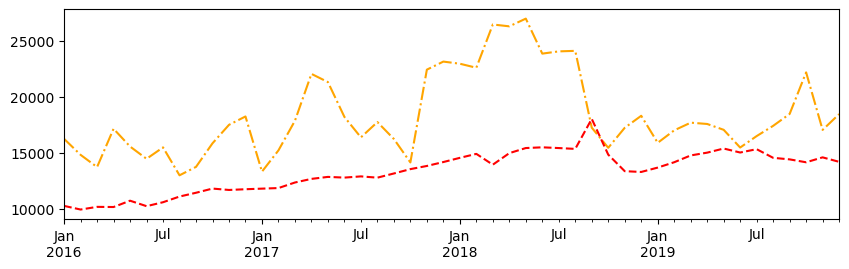

In [13]:
new_psf = HK[(HK['Sale_Type']=='NEW')].resample('1M').mean()
old_psf = HK[(HK['Sale_Type']=='RESALE')].resample('1M').mean()
difference_psf = new_psf['NET_PSF'].mean() - old_psf['NET_PSF'].mean()

fig = plt.figure(1, figsize=(10,6))
grid = gs.GridSpec(2, 1, height_ratios=[1,1])
ax1 = plt.subplot(grid[0,0])

new_psf ['NET_PSF'].plot(ls='-.', c='orange', label='NEAR_MRT', ax=ax1)
old_psf['NET_PSF'].plot(ls='--', c='red', label='NOT NEAR MRT', ax=ax1)

new_psf['NET_PSF'].mean() - old_psf['NET_PSF'].mean()

In [14]:
HK['Sale_Type'].groupby(HK['BuildingAge']).value_counts(sort=True)
# 3 is more than 20 years 
# 2 is 10- 20 years
# 1 is within 10 years 
# 0 new flat 

BuildingAge  Sale_Type
0            NEW           56539
1            RESALE        26776
2            RESALE        39900
3            RESALE       114802
Name: Sale_Type, dtype: int64

In [15]:
HK['Sale_Type'].groupby(HK['Sale_Year']).value_counts()

Sale_Year  Sale_Type
2016       RESALE       44753
           NEW          14701
2017       RESALE       49143
           NEW          15228
2018       RESALE       48478
           NEW           8570
2019       RESALE       39104
           NEW          18040
Name: Sale_Type, dtype: int64

<Axes: ylabel='Sale_Type'>

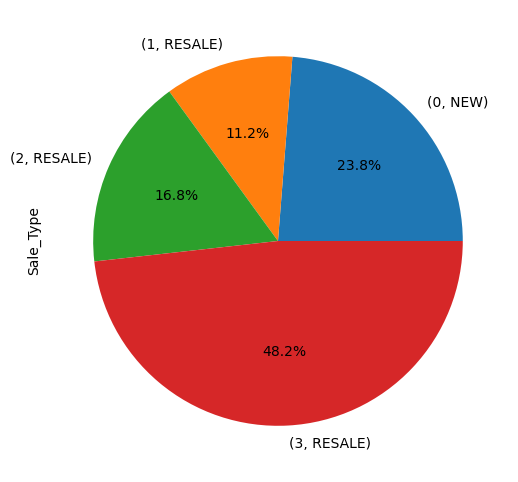

In [16]:
HK['Sale_Type'].groupby(HK['BuildingAge']).value_counts().plot(kind='pie',autopct= '%1.1f%%', figsize=(8,6))

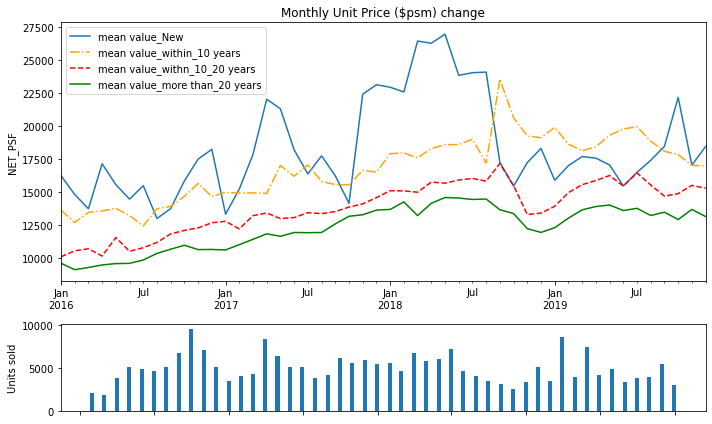

In [11]:
minton_0 = HK[HK['BuildingAge']==0].resample('1M').mean()
minton_1 = HK[HK['BuildingAge']==1].resample('1M').mean()
minton_2 = HK[HK['BuildingAge']==2].resample('1M').mean()
minton_3 = HK[HK['BuildingAge']==3].resample('1M').mean()
minton_count = HK.resample('1M').count()
fig = plt.figure(1, figsize=(10,6))
grid = gs.GridSpec(2, 1, height_ratios=[3,1])
ax1 = plt.subplot(grid[0,0])
ax2 = plt.subplot(grid[1,0])
minton_0['NET_PSF'].plot(ls='-', label='mean value_New', ax=ax1)
minton_1['NET_PSF'].plot(ls='-.', c='orange', label='mean value_within_10 years', ax=ax1)
minton_2['NET_PSF'].plot(ls='--', c='red', label='mean value_withn_10_20 years', ax=ax1)
minton_3['NET_PSF'].plot(ls='-', c='green', label='mean value_more than_20 years', ax=ax1)
ax1.set_title('Monthly Unit Price ($psm) change')
ax1.set_ylabel('NET_PSF')
ax1.legend(loc='upper left')
ax2.bar(minton_count.index, minton_count['Project_Name'], width=10)
ax2.set_ylabel('Units sold')
ax2.set_xticklabels('')
plt.tight_layout()
plt.show()

In [12]:
pricechange_new = minton_0['NET_PSF'].T[minton_0['NET_PSF'].index[-1]] / minton_0['NET_PSF'].T[minton_0['NET_PSF'].index[0]] -1
pricechange_10 = minton_1['NET_PSF'].T[minton_1['NET_PSF'].index[-1]] / minton_1['NET_PSF'].T[minton_1['NET_PSF'].index[0]] -1
pricechange_20 = minton_2['NET_PSF'].T[minton_2['NET_PSF'].index[-1]] / minton_2['NET_PSF'].T[minton_2['NET_PSF'].index[0]] -1
pricechange_old = minton_3['NET_PSF'].T[minton_3['NET_PSF'].index[-1]] / minton_3['NET_PSF'].T[minton_3['NET_PSF'].index[0]] -1
pricechange_new,pricechange_10,pricechange_20,pricechange_old


(0.13556684768735172,
 0.24500062342024065,
 0.5141292794758427,
 0.36801156803906965)


### Q2 ) Near MRT or Not -->Location Premium ?

In [13]:
STATION = HK.groupby('MRT')[['NET_PSF','lat','long','Distance_TO_MRT']].mean().reset_index()

In [14]:
top_dollars = STATION.sort_values('NET_PSF', ascending=False).iloc[:10]
top_dollars

,MRT,NET_PSF,lat,long,Distance_TO_MRT
29,Kowloon Station,32094.533884,22.304139,114.162326,0.183972
49,Ocean Park Station,28006.422492,22.234151,114.198863,3.393613
1,Admiralty Station,24908.971193,22.275046,114.163808,0.631744
4,Central Station,23664.678619,22.277241,114.154013,0.723899
22,Hong Kong Station,22941.324201,22.281788,114.152646,0.466958
46,Nam Cheong Station,22309.492632,22.327374,114.154025,0.123251
16,HKU Station,21645.795605,22.285647,114.135601,0.291672
56,Sai Ying Pun Station,20959.686367,22.285626,114.142604,0.309350
30,Kowloon Tong Station,20911.945860,22.338914,114.175362,0.632911
44,Mong Kok East Station,20644.239433,22.320444,114.178537,0.790227


In [15]:
#OVERALL = HK[(HK['Distance_TO_MRT'] < 0.5)].mean()
#OVERALL_ = HK[(HK['Distance_TO_MRT'] > 0.5)].mean()

NEW = HK[(HK['BuildingAge'] == 0 ) & (HK['Distance_TO_MRT'] < 0.5)].resample('1M').mean()
NEW_ = HK[(HK['BuildingAge'] == 0 ) & (HK['Distance_TO_MRT'] > 0.5)].resample('1M').mean()

WITHIN10 = HK[(HK['BuildingAge'] == 1 ) & (HK['Distance_TO_MRT'] < 0.5)].resample('1M').mean()
WITHIN10_ = HK[(HK['BuildingAge'] == 1 ) & (HK['Distance_TO_MRT'] > 0.5)].resample('1M').mean()

WITHIN20 = HK[(HK['BuildingAge'] == 2 ) & (HK['Distance_TO_MRT'] < 0.5)].resample('1M').mean()
WITHIN20_ = HK[(HK['BuildingAge'] == 2 ) & (HK['Distance_TO_MRT'] > 0.5)].resample('1M').mean()

OTHER = HK[(HK['BuildingAge'] == 3 ) & (HK['Distance_TO_MRT'] < 0.5)].resample('1M').mean()
OTHER_ = HK[(HK['BuildingAge'] == 3 ) & (HK['Distance_TO_MRT'] > 0.5)].resample('1M').mean()


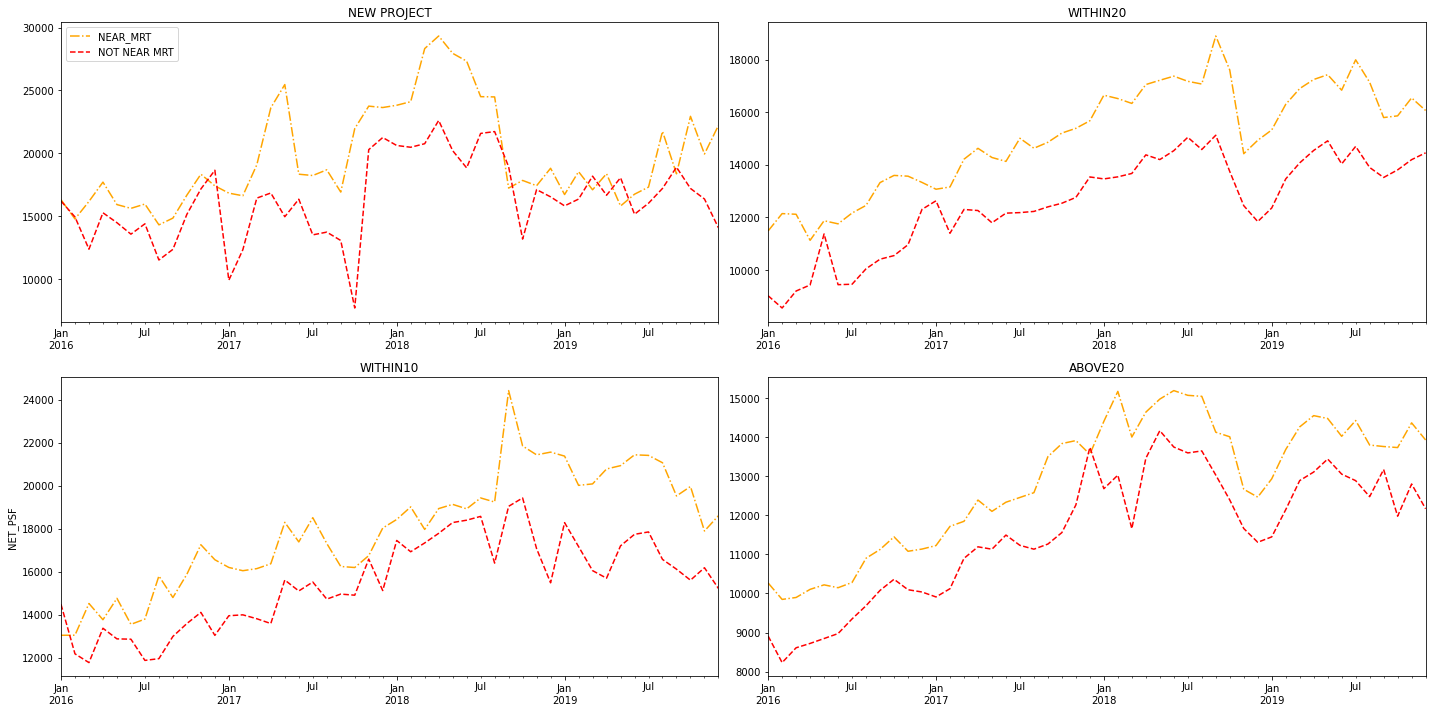

In [16]:
#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize(10,6))

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20,10))
ax1 = plt.subplot(axes[0,0])
ax2 = plt.subplot(axes[1,0])
ax3 = plt.subplot(axes[0,1])
ax4 = plt.subplot(axes[1,1])

NEW['NET_PSF'].plot(ls='-.', c='orange', label='NEAR_MRT', ax=ax1)
NEW_['NET_PSF'].plot(ls='--', c='red', label='NOT NEAR MRT', ax=ax1)

WITHIN10['NET_PSF'].plot(ls='-.', c='orange', label='NEAR_MRT', ax=ax2)
WITHIN10_['NET_PSF'].plot(ls='--', c='red', label='NOT NEAR MRT', ax=ax2)

WITHIN20['NET_PSF'].plot(ls='-.', c='orange', label='NEAR_MRT', ax=ax3)
WITHIN20_['NET_PSF'].plot(ls='--', c='red', label='NOT NEAR MRT', ax=ax3)

OTHER['NET_PSF'].plot(ls='-.', c='orange', label='NEAR_MRT', ax=ax4)
OTHER_['NET_PSF'].plot(ls='--', c='red', label='NOT NEAR MRT', ax=ax4)

ax1.set_title('NEW PROJECT')
ax2.set_title('WITHIN10')
ax3.set_title('WITHIN20')
ax4.set_title('ABOVE20')
ax2.set_ylabel('NET_PSF')
ax1.legend(loc='upper left')
plt.tight_layout()
plt.show()


In [17]:
PREMIUM_NEW = NEW - NEW_
PREMIUM_10 = WITHIN10 - WITHIN10_
PREMIUM_20 = WITHIN20 - WITHIN20_
PREMIUM_OLD = OTHER - OTHER_

<AxesSubplot:>

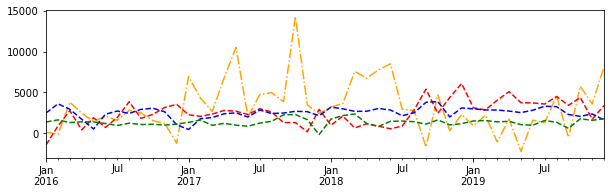

In [18]:
fig = plt.figure(1, figsize=(10,6))
grid = gs.GridSpec(2, 1, height_ratios=[1,1])
ax1 = plt.subplot(grid[0,0])

PREMIUM_NEW['NET_PSF'].plot(ls='-.', c='orange', label='NEAR_MRT', ax=ax1)
PREMIUM_10['NET_PSF'].plot(ls='--', c='red', label='NOT NEAR MRT', ax=ax1)
PREMIUM_20['NET_PSF'].plot(ls='--', c='blue', label='NOT NEAR MRT', ax=ax1)
PREMIUM_OLD['NET_PSF'].plot(ls='--', c='green', label='NOT NEAR MRT', ax=ax1)

In [19]:
PREIMIUM = [PREMIUM_NEW['NET_PSF'].mean(), PREMIUM_10['NET_PSF'].mean(),PREMIUM_20['NET_PSF'].mean(),PREMIUM_OLD['NET_PSF'].mean()]
PREIMIUM

[3317.64199639398, 2476.9406255041768, 2509.0068682384963, 1331.0411016976805]

In [20]:
#3 --> before 2005 
#2--> 2005 -2010
#1 --> 2010-2016
#0 --> 2017 and above 

### Q3) With Amenities is more expensive ?

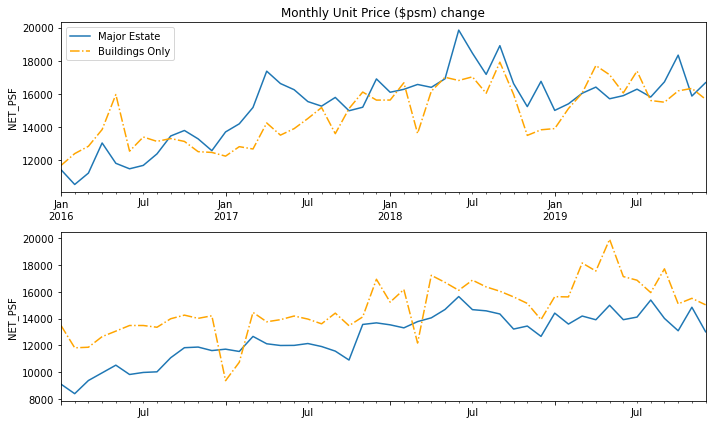

In [21]:
minton_0 = HK[(HK['Property_Type']=='E') & (HK['Distance_TO_MRT'] < 0.5)].resample('1M').mean()
minton_1 = HK[(HK['Property_Type']=='B') & (HK['Distance_TO_MRT'] < 0.5)].resample('1M').mean()

minton_2 = HK[(HK['Property_Type']=='E') & (HK['Distance_TO_MRT'] > 0.5)].resample('1M').mean()
minton_3 = HK[(HK['Property_Type']=='B') & (HK['Distance_TO_MRT'] > 0.5)].resample('1M').mean()
minton_count = HK.resample('1M').count()
fig = plt.figure(1, figsize=(10,6))
grid = gs.GridSpec(2, 1, height_ratios=[1,1])
ax1 = plt.subplot(grid[0,0])
ax2 = plt.subplot(grid[1,0])
minton_0['NET_PSF'].plot(ls='-', label='Major Estate', ax=ax1)
minton_1['NET_PSF'].plot(ls='-.', c='orange', label='Buildings Only', ax=ax1)

ax1.set_title('Monthly Unit Price ($psm) change')
ax1.set_ylabel('NET_PSF')
ax1.legend(loc='upper left')
minton_2['NET_PSF'].plot(ls='-', label='Major Estate', ax=ax2)
minton_3['NET_PSF'].plot(ls='-.', c='orange', label='Buildings Only', ax=ax2)
ax2.set_ylabel('NET_PSF')
ax2.set_xticklabels('')
plt.tight_layout()
plt.show()

In [22]:
#2) Most Expensive square feet of real estate sold in HK
HK[(HK['NET_PSF']==HK['NET_PSF'].max())]

,Project_Name,INST_DATE,Sale_Type,Property_Type,Sale_Year,D_CODE,BuildingAge,UnitSize,FLOOR,FloorType,combined_address,Distance_TO_MRT,TOTNFA,NET_PSF,lat,long,MRT,CBD,Transaction_Price
2016-11-08,THE ARCH,11/8/2016,RESALE,E,2016,KSWK,2,5,80,0,"THE ARCH BLOCK 2A MOON TOWER, 1 AUSTIN RD W",0.232386,4263.0,99414,22.303189,114.163243,Kowloon Station,2.423491,423800000.0
2016-10-01,THE ARCH,10/1/2016,RESALE,E,2016,KSWK,2,5,80,0,"THE ARCH BLOCK 2A MOON TOWER, 1 AUSTIN RD W",0.232386,4263.0,99414,22.303189,114.163243,Kowloon Station,2.423491,423800000.0


In [23]:
#2) Most Expensive Absolute Value of real estate sold in HK
HK[HK['Transaction_Price']==HK['Transaction_Price'].max()]

,Project_Name,INST_DATE,Sale_Type,Property_Type,Sale_Year,D_CODE,BuildingAge,UnitSize,FLOOR,FloorType,combined_address,Distance_TO_MRT,TOTNFA,NET_PSF,lat,long,MRT,CBD,Transaction_Price
2016-11-04,MOUNT NICHOLSON,11/4/2016,NEW,E,2016,HP,0,5,12,2,"MOUNT NICHOLSON BLOCK A-B PHASE 2 , 8 MOUNT NI...",1.736652,8812.0,85000,22.263238,114.180522,Ocean Park Station,3.282023,749020000.0
2016-10-28,MOUNT NICHOLSON,10/28/2016,NEW,E,2016,HP,0,5,12,2,"MOUNT NICHOLSON BLOCK A-B PHASE 2 , 8 MOUNT NI...",1.736652,8812.0,85000,22.263238,114.180522,Ocean Park Station,3.282023,749020000.0


In [24]:
#1) Largest real estate by area sold 
#HK[HK['TOTNFA']==HK['TOTNFA'].max()]

In [25]:
# Average unit prices and average square area for each project_name
streets = HK.groupby('combined_address')[['TOTNFA', 'NET_PSF','lat','long','Property_Type']].mean().reset_index()

In [26]:
streets['weights'] = streets['NET_PSF']/streets['NET_PSF'].max()
hist, bin_edges = np.histogram( streets['weights'])

In [27]:
import folium
#import shapefile
import colorsys
# Define colors for the colorbar
colors = []
for w in bin_edges:
    c = '#%02x%02x%02x' % tuple(map(lambda x: int(x*255), colorsys.hsv_to_rgb(w, 1, 0.5)))
    colors.append(c)

In [28]:
base_map = folium.Map(location=[22.3193, 114.16944], zoom_start=12)
streets = streets[1:]
from folium.plugins import HeatMap


In [29]:
# Price Heat Map 
map_values1 = streets[['lat','long','weights']]
data = map_values1.values.tolist()
hm = HeatMap(data,gradient={0.1: 'blue', 0.3: 'lime', 0.5: 'yellow', 0.7: 'orange', 1: 'red'}, 
                min_opacity=0.05, 
                max_opacity=0.9, 
                radius=25,
                use_local_extrema=False)#.add_to(base_map)
base_map.add_child(hm)

In [30]:
# Number of real estates sold at each address
num_sold = HK.groupby('combined_address')['Project_Name'].count()
num_mean = num_sold.mean()
num_sold.describe()

count    14116.000000
mean        16.861505
std         33.059448
min          1.000000
25%          2.000000
50%          7.000000
75%         19.000000
max        681.000000
Name: Project_Name, dtype: float64

In [31]:
# The most expensive real estate projects in HK(psf)
HKK = HK.groupby(['Project_Name', 'combined_address', 'TOTNFA', 
                        'Transaction_Price'])['NET_PSF'].max().reset_index()
top = HKK.sort_values('Transaction_Price', ascending=False)
top.head(10)

,Project_Name,combined_address,TOTNFA,Transaction_Price,NET_PSF
114310,MOUNT NICHOLSON,"MOUNT NICHOLSON BLOCK A-B PHASE 2 , 8 MOUNT NI...",8812.0,749020000.0,85000
114308,MOUNT NICHOLSON,"MOUNT NICHOLSON BLOCK A-B PHASE 2 , 8 MOUNT NI...",8792.0,685776000.0,78000
114314,MOUNT NICHOLSON,"MOUNT NICHOLSON BLOCK A-B PHASE 2 , 8 MOUNT NI...",8855.0,652000000.0,73631
114313,MOUNT NICHOLSON,"MOUNT NICHOLSON BLOCK A-B PHASE 2 , 8 MOUNT NI...",8855.0,646415000.0,73000
114312,MOUNT NICHOLSON,"MOUNT NICHOLSON BLOCK A-B PHASE 2 , 8 MOUNT NI...",8855.0,644644000.0,72800
114311,MOUNT NICHOLSON,"MOUNT NICHOLSON BLOCK A-B PHASE 2 , 8 MOUNT NI...",8855.0,593285000.0,67000
114309,MOUNT NICHOLSON,"MOUNT NICHOLSON BLOCK A-B PHASE 2 , 8 MOUNT NI...",8800.0,568000000.0,64545
114323,MOUNT NICHOLSON,"MOUNT NICHOLSON BLOCK D PHASE 3 , 8 MOUNT NICH...",4596.0,455004000.0,99000
114322,MOUNT NICHOLSON,"MOUNT NICHOLSON BLOCK D PHASE 3 , 8 MOUNT NICH...",4596.0,444276900.0,96666
114321,MOUNT NICHOLSON,"MOUNT NICHOLSON BLOCK D PHASE 3 , 8 MOUNT NICH...",4596.0,441216000.0,96000


#### Machine Learning Real Estate Prediction 
#### Step 3: Feature Selection and Drop the Column 

In [32]:
from sklearn import preprocessing
from sklearn import metrics 
from sklearn.model_selection  import train_test_split
from sklearn.model_selection  import KFold, cross_val_score,RepeatedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model

In [33]:
le = preprocessing.LabelEncoder()
for column in HK.describe(include='object').columns:
    HK[column] = le.fit_transform(HK[column])

In [34]:
HK.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 238017 entries, 2019-12-31 to 2016-01-01
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Project_Name       238017 non-null  int32  
 1   INST_DATE          238017 non-null  int32  
 2   Sale_Type          238017 non-null  int32  
 3   Property_Type      238017 non-null  int32  
 4   Sale_Year          238017 non-null  int64  
 5   D_CODE             238017 non-null  int32  
 6   BuildingAge        238017 non-null  int64  
 7   UnitSize           238017 non-null  int64  
 8   FLOOR              238017 non-null  int64  
 9   FloorType          238017 non-null  int64  
 10  combined_address   238017 non-null  int32  
 11  Distance_TO_MRT    238017 non-null  float64
 12  TOTNFA             238017 non-null  float64
 13  NET_PSF            238017 non-null  int64  
 14  lat                238017 non-null  float64
 15  long               238017 non-null 

In [35]:
HK_ = HK.drop(['INST_DATE','lat','long','Transaction_Price',"NET_PSF"],axis =1)
y = HK['NET_PSF']

In [36]:
# Predictivity
pearson = HK_.corr('pearson')
pearson.iloc[-1][:-1].sort_values()

MRT                -0.203510
Sale_Type          -0.109663
BuildingAge        -0.093247
Project_Name       -0.033070
combined_address   -0.032975
FloorType          -0.003636
FLOOR              -0.001435
D_CODE              0.006077
TOTNFA              0.029706
UnitSize            0.036064
Property_Type       0.037798
Sale_Year           0.039465
Distance_TO_MRT     0.922012
Name: CBD, dtype: float64

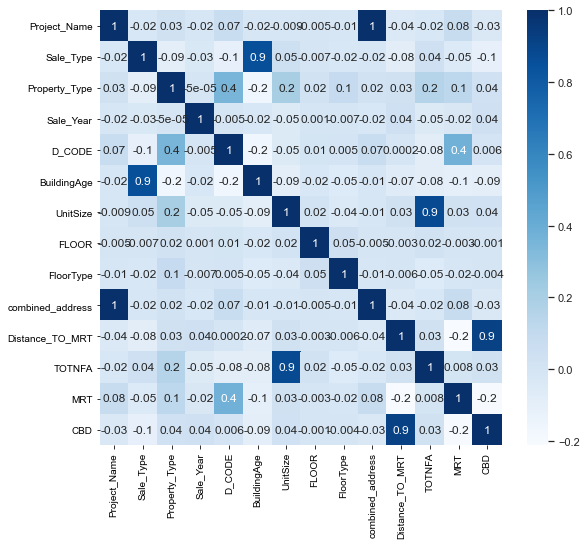

In [37]:
# Correlation matrix as heatmap (seaborn)
fig, ax = plt.subplots(figsize=(9,8))
sns.set_theme(style="white")
corr = HK_.corr()
heatmap = sns.heatmap(corr,annot=True,cmap="Blues",fmt='.1g')

In [38]:
# Split data into train and test leaving last ten (500) rows for the final evaluation
X_train, X_test, y_train, y_test = train_test_split(HK_.iloc[:-500], y.iloc[:-500], test_size=0.2)

In [39]:
print('Database size: {:g} \nTrain set size: {:g} \nTest set size: {:g} \nValidate set size: {:g}'
      .format(len(HK_), len(y_train), len(y_test), len(HK_)-(len(y_train)+len(y_test))))

Database size: 238017 
Train set size: 190013 
Test set size: 47504 
Validate set size: 500


In [40]:
# Scale data
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### STEP 4 : APPLYING MACHINE LEARNING MODEL

In [41]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree  import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.metrics import explained_variance_score,mean_squared_error,r2_score

In [42]:
# Train & evaluate model performance
def train_and_evaluate(model, X, y):
    mol,score_,exp_var,r2_,mse_ = [],[],[],[],[]
    model.fit(X, y)
    print('Score on training set: {:g}'.format(model.score(X, y)))
    # k-fold cross validation iterator of 5 folds
    cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=100)
    scores = cross_val_score(model, X, y, cv=cv)
    
    predictions = currentmodel.predict(X_test)
    exp_variance = explained_variance_score(y_test,predictions)
    r2=r2_score(y_test,predictions)
    mse=mean_squared_error(y_test,predictions)

    mol.append(algos[model_[0]][0])
    score_.append(np.mean(scores))
    exp_var.append(exp_variance)
    r2_.append(r2)
    mse_.append(mse)
    print({"model":mol,"Score":score_,"VarianceScore":exp_var,"R2":r2_,"MSE":mse_}) 
    return {"model":mol,"Training_Score":score_,"Test_score":exp_var,"R2":r2_,"MSE":mse_}
    

In [43]:
algos = [["DecisionTree",DecisionTreeRegressor()],
         ["RandomForest",RandomForestRegressor(n_estimators=400,random_state=0)],
         ["LightGBM",LGBMRegressor(n_estimators= 5000, max_depth=20, random_state=123, n_jobs=4, reg_alpha=0.5, reg_lambda=0.9)],
         #["GradientBoost",GradientBoostingRegressor(n_estimators=400, max_depth=5, loss='ls',min_samples_split=2,learning_rate=0.1)],
         ["AdaBoost",AdaBoostRegressor(n_estimators=50, learning_rate=0.5,loss='exponential')],
         ["XGBoost",XGBRegressor(n_estimators=450, learning_rate=0.5, gamma=0, subsample=0.75,colsample_bytree=1, max_depth=7)]
        ]

In [44]:
result_ = {}
for model_ in enumerate(algos):
    currentmodel =algos[model_[0]][1]
    result = train_and_evaluate(currentmodel, X_train, y_train.ravel())
result_.update(result)

Score on training set: 0.997693
{'model': ['DecisionTree'], 'Score': [0.7614651081936777], 'VarianceScore': [0.7656264731744357], 'R2': [0.7656087440386568], 'MSE': [8460491.403930588]}
Score on training set: 0.980902
{'model': ['RandomForest'], 'Score': [0.8637207020652333], 'VarianceScore': [0.8653257129564146], 'R2': [0.8652816500318641], 'MSE': [4862738.7450200105]}
[LightGBM] [Warning] early_stopping_round is set=1, early_stopping_rounds=1 will be ignored. Current value: early_stopping_round=1


ValueError: For early stopping, at least one dataset and eval metric is required for evaluation

In [45]:
train_result = pd.DataFrame(result_)
train_result

,model,Training_Score,Test_score,R2,MSE
0,RandomForest,0.863721,0.865326,0.865282,4.862739e+06


### Prediction Unseen Data 

In [ ]:
# Pedict price for new apartments (not seen before)
x_new = HK_.iloc[-500:]  # example
# Scale data
x_new = scaler.transform(x_new)
# True values (actual prices)
true_values = y.iloc[-500:].values

In [ ]:
result_pred = {} 
for model_ in enumerate(algos):
    currentmodel =algos[model_[0]][1]
    result_pred = train_and_evaluate(currentmodel, X_train, y_train.ravel())
    

In [ ]:
validate_result = pd.DataFrame(result)
validate_result